# image-level analysis

In [1]:
from collections import defaultdict
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyprojroot
import seaborn as sns
import scipy.stats
import sklearn.metrics
from sklearn.preprocessing import KBinsDiscretizer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

import searchnets
from searchnets import nets
from searchnets.datasets import VOCDetection
from searchnets.engine.abstract_trainer import AbstractTrainer
from searchnets.transforms.util import get_transforms
from searchnets.transforms.functional import tile
from searchnets.utils.general import make_save_path

## constants

In [2]:
VSD_RESULTS_ROOT = pyprojroot.here().joinpath('results/VSD')

VSD_TEST_RESULTS_ROOT = VSD_RESULTS_ROOT.joinpath('test_results')

## get all the `assay_images` csvs from each model / net / mode / method, concatenate

In [3]:
assay_images_csvs = sorted(VSD_TEST_RESULTS_ROOT.glob('**/*assay_images.csv'))

before loading all csvs:
* load one and discretize visual search difficulty scores
  - we choose the bins using the first csv, all will be the same (it's always the same test set)
    + choose **before** filtering further 
      because we want bins to capture the entire range of scores
      - e.g. if we bin after filtering to keep only images with single items, this will change the range
        and the width of the bins
    + we choose bins so that each has same # of samples, 
      instead of having equal width bins

In [4]:
first_csv_df = pd.read_csv(assay_images_csvs[0])

N_BINS = 8

discretizer = KBinsDiscretizer(n_bins=N_BINS, encode='ordinal', strategy='quantile')
vsd_score_bin = discretizer.fit_transform(first_csv_df['vsd_score'].values.reshape(-1, 1))
vsd_score_bin = pd.Series(vsd_score_bin.ravel()).astype('category')
# single_label_df['vsd_score_bin'] = vsd_score_bin

now we load all `assay_images` csvs and add `vsd_score_bin` column that we just made to each one

In [5]:
df_list = []

for assay_images_csv in assay_images_csvs:
    df = pd.read_csv(assay_images_csv)
    df['vsd_score_bin'] = vsd_score_bin
    df_list.append(df)

assay_images_df = pd.concat(
    df_list
)

COLUMNS = [
    'net_name',
    'replicate',
    'mode',
    'method',
    'loss_func',    
    'TP',
    'TN',
    'FN',
    'FP',
    'vsd_score',
    'vsd_score_bin',
    'n_items',
    'img_name',
    'img_path',
    'restore_path',   
    'voc_test_index',
]

assay_images_df = assay_images_df[COLUMNS]

## use `groupby` to compute accuracy for each experimental level, including the visual search difficulty score (binned)

### declare labels to group by experiment levels **and** visual search difficulty score (bin)
(used multiple times below)

In [6]:
GROUP_LABELS = ['net_name', 'replicate', 'mode', 'method', 'loss_func', 'vsd_score_bin']

### measure accuracy as a function of (binned) visual search difficulty scores
#### first for just cases where there is only 1 item in image

- filter by loss function: we only want single-label classification, so remove 'BCE'
- also filter by number of objects / items, we only want images with one object present

In [7]:
single_label_df = assay_images_df[assay_images_df.loss_func.isin(['CE-largest', 'CE-random'])]
single_label_df = single_label_df[single_label_df['n_items'] == 1]

- then split into groups that correspond to experimental levels + variables of interest

In [8]:
single_label_gb = single_label_df.groupby(GROUP_LABELS)
single_label_groups = single_label_gb.groups

* finally create new dataframe where each experimental level has a corresponding accuracy measure

In [9]:
def acc(df):
    assert np.all(df['TP'].isin([0, 1])), "not all true positive values were zero or one"
    return df['TP'].sum() / len(df)

In [10]:
single_label_records = defaultdict(list)

for a_group in sorted(single_label_groups.keys()):
    a_group_df = single_label_gb.get_group(a_group)

    for grp_label, grp_val in zip(GROUP_LABELS, a_group):
        single_label_records[grp_label].append(grp_val)

    # treat each image as a 'trial'
    single_label_records['n_trials'].append(len(a_group_df))
        
    single_label_records['acc'].append(
        acc(a_group_df)
    )

single_label_acc_df = pd.DataFrame.from_records(single_label_records)

### declare COLUMNS for accuracy `DataFrame`s -- will use the same columns for multi-label accuracy

In [23]:
ACC_COLUMNS = [
    'method',
    'mode', 
    'loss_func',    
    'net_name',
    'replicate',
    'vsd_score_bin',
    'acc',
    'n_trials',
]

single_label_acc_df = single_label_acc_df[ACC_COLUMNS]

In [24]:
single_label_acc_df.head()

,method,mode,loss_func,net_name,replicate,vsd_score_bin,acc,n_trials
0,initialize,classify,CE-largest,CORnet_S,1,0.0,0.621622,333
1,initialize,classify,CE-largest,CORnet_S,1,1.0,0.553746,307
2,initialize,classify,CE-largest,CORnet_S,1,2.0,0.525362,276
3,initialize,classify,CE-largest,CORnet_S,1,3.0,0.490654,214
4,initialize,classify,CE-largest,CORnet_S,1,4.0,0.470270,185


#### now measure accuracy for images with any number of objects, using networks trained for multi-label classificaiton

- filter by loss function: we want multi-label classification, so keep only 'BCE'

In [25]:
multi_label_df = assay_images_df[assay_images_df.loss_func.isin(['BCE'])]

In [26]:
multi_label_gb = multi_label_df.groupby(GROUP_LABELS)
multi_label_groups = multi_label_gb.groups

In [27]:
def multi_label_acc(df):
    acc_series = df['TP'] / (df['TP'] + df['FN'])
    return acc_series.mean()

In [28]:
multi_label_records = defaultdict(list)

for a_group in sorted(multi_label_groups.keys()):
    a_group_df = multi_label_gb.get_group(a_group)

    for grp_label, grp_val in zip(GROUP_LABELS, a_group):
        multi_label_records[grp_label].append(grp_val)

    # treat each image as a 'trial'
    multi_label_records['n_trials'].append(len(a_group_df))
        
    multi_label_records['acc'].append(
        multi_label_acc(a_group_df)
    )

multi_label_acc_df = pd.DataFrame.from_records(multi_label_records)

In [29]:
multi_label_acc_df = multi_label_acc_df[ACC_COLUMNS]

In [30]:
multi_label_acc_df.head()

,method,mode,loss_func,net_name,replicate,vsd_score_bin,acc,n_trials
0,initialize,classify,BCE,CORnet_S,1,0.0,0.167614,352
1,initialize,classify,BCE,CORnet_S,1,1.0,0.128726,369
2,initialize,classify,BCE,CORnet_S,1,2.0,0.152739,359
3,initialize,classify,BCE,CORnet_S,1,3.0,0.136427,361
4,initialize,classify,BCE,CORnet_S,1,4.0,0.133433,336


## plot figure

In [35]:
acc_df = pd.concat((single_label_acc_df, multi_label_acc_df))

In [58]:
def show_all_fonts():
    import matplotlib.font_manager
    print(
        matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
    )

In [62]:
def cm_to_inches(cm):
    return cm / 2.54

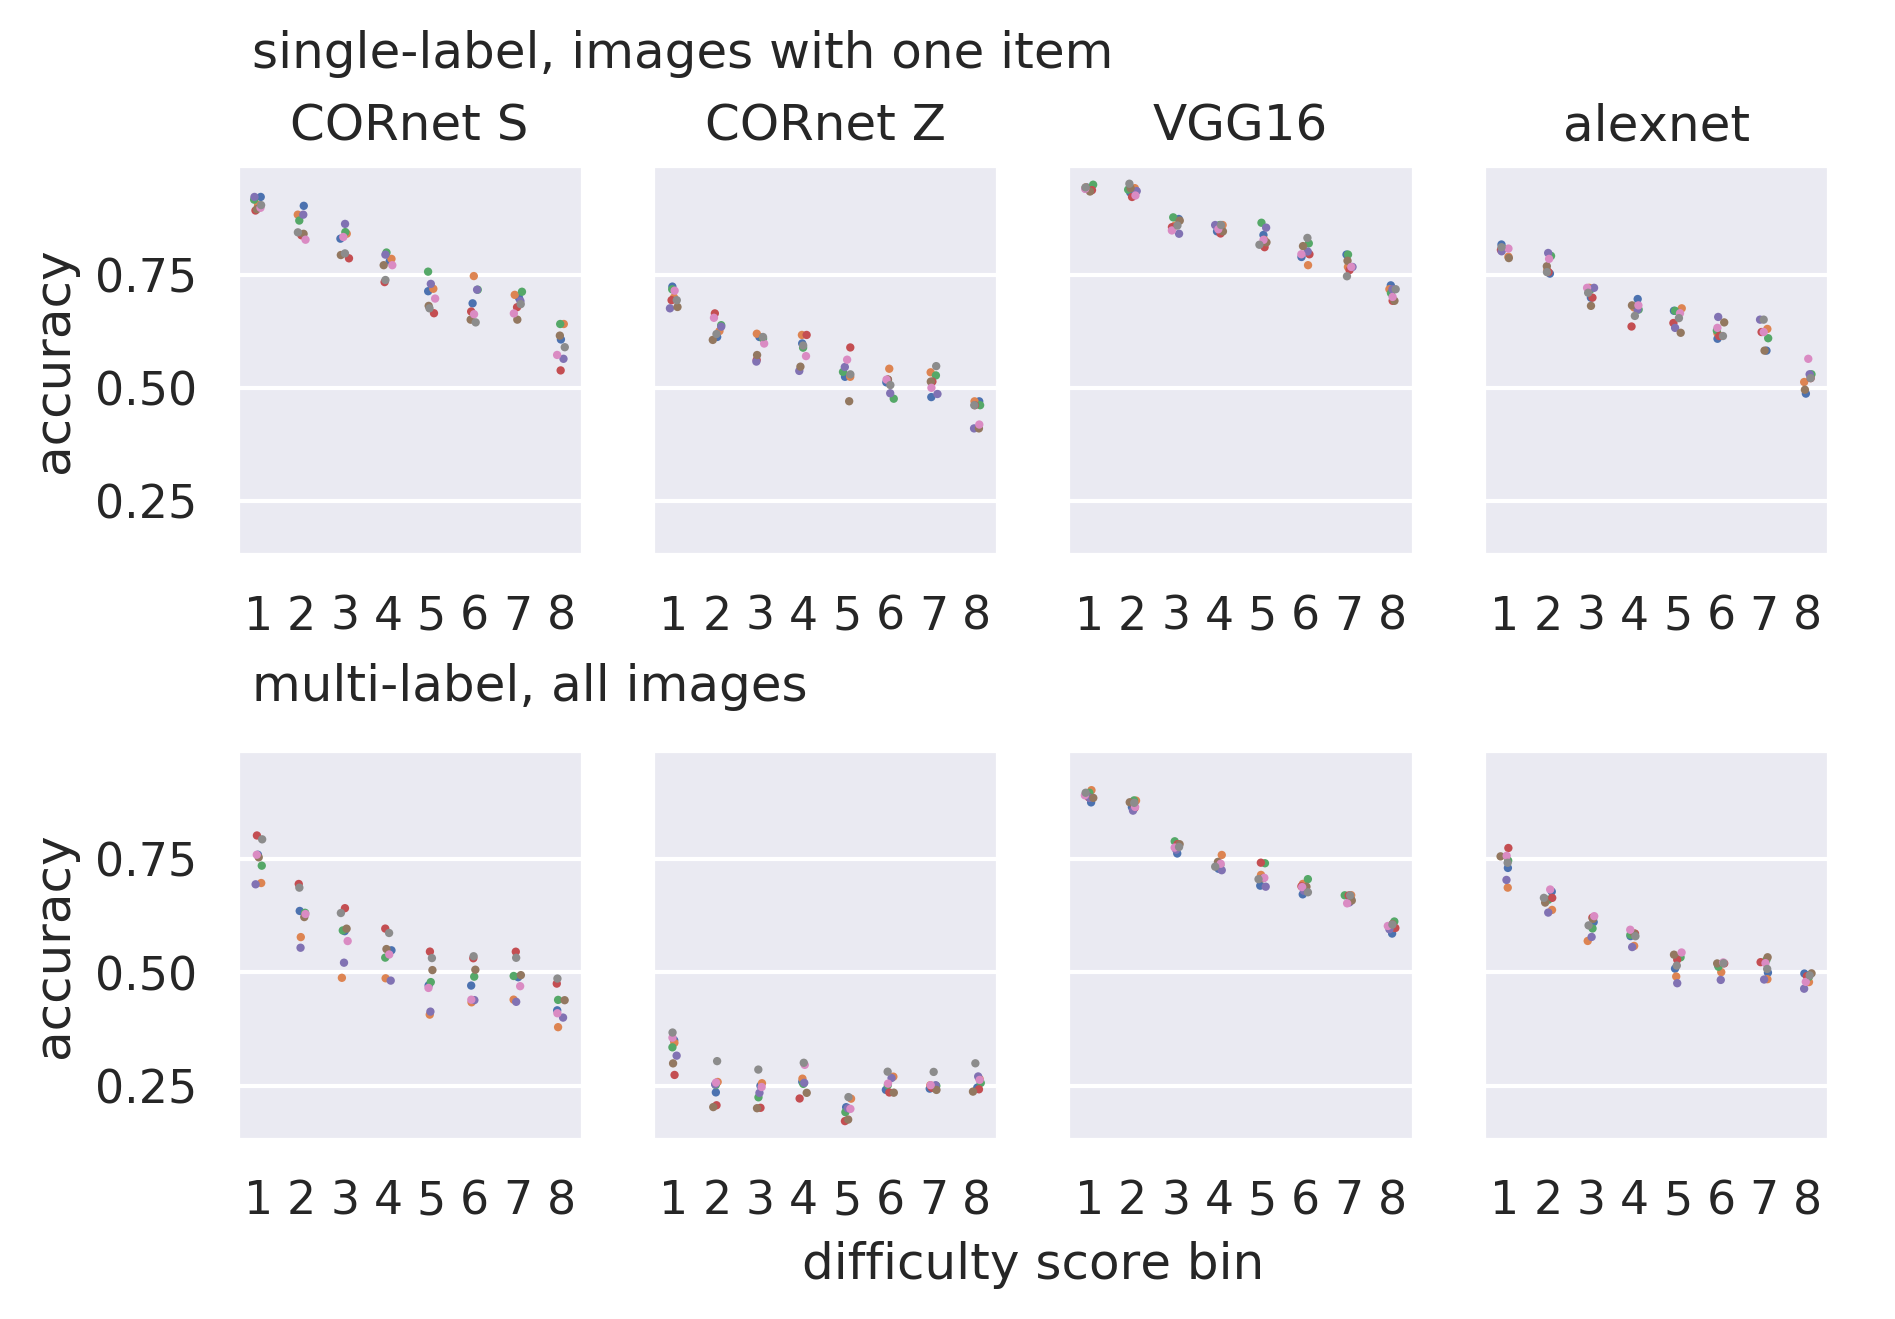

In [99]:
sns.set()

nrow = 2  # single-label, multi-labvel
ncol = 4  # number of neural network architectures

FIGSIZE = tuple(cm_to_inches(size) for size in (17.4, 10))
DPI = 300
fig, ax = plt.subplots(nrow, ncol, figsize=FIGSIZE, dpi=DPI, sharey=True)
for mode in ['classify']:
    for method in ['transfer']:
        for row, loss_func in enumerate(['CE-random', 'BCE']):
            for col, net_name in enumerate(acc_df['net_name'].unique()):
                sub_df = acc_df[
                    (acc_df['mode'] == mode) &
                    (acc_df['method'] == method) &
                    (acc_df['loss_func'] == loss_func) &
                    (acc_df['net_name'] == net_name)
                ]
                if len(sub_df) == 0:
                    continue

                sns.stripplot(x="vsd_score_bin", y="acc", hue="replicate", data=sub_df, ax=ax[row, col], size=2)
                ax[row, col].get_legend().remove()
                ax[row, col].set_xlabel('')
                xticklabels = range(1, len(acc_df['vsd_score_bin'].unique()) + 1)
                ax[row, col].set_xticklabels(xticklabels)
                if row == 0:
                    ax[row, col].set_title(net_name.replace('_', ' '))
                if col == 0:
                    ax[row, col].set_ylabel('accuracy')
                else:
                    ax[row, col].set_ylabel('')
            # g.fig.suptitle(f'accuracy as a function of visual search difficulty score,\nimages with only one item', y=1.05)

big_ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.grid(False)
big_ax.set_xlabel("difficulty score bin")
big_ax.text(0.01, 1.1, "single-label, images with one item")
big_ax.text(0.01, 0.45, "multi-label, all images")


# fig.tight_layout(h_pad=2)
fig.subplots_adjust(top = 0.95, hspace=0.5)

for ext in ('svg', 'png'):
    fig_path = pyprojroot.here().joinpath(
        f'docs/paper/fig4/fig4.{ext}'
    )
    plt.savefig(fig_path)